In [8]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler, Sampler
from torch.autograd import Variable
from torch.nn.init import xavier_normal, kaiming_normal
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import random

DATA_DIR = 'Data/'
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

categorical_features = set(['skill',
                        'problemId',
                        'assignmentId',
                        'assistmentId',
                        'problemType'])

In [4]:
pickle_train = open(DATA_DIR + "student_train_logs.pickle","rb")
train = pickle.load(pickle_train)

train[9][0].head()

,timeTaken,correct,original,hint,hintCount,hintTotal,scaffold,bottomHint,attemptCount,frIsHelpRequest,...,problemType_2,skill_0,skill_1,skill_2,problemId_0,problemId_1,problemId_2,assistmentId_0,assistmentId_1,assistmentId_2
184889,0.001500,0,1,1,0.017857,0.017857,0,0,0.0,1,...,0.787083,0.797780,-0.679086,-0.588489,-0.419237,1.038977,0.358298,1.295625,0.206861,-2.427553
184890,0.009601,1,0,0,0.000000,0.000000,1,0,0.0,1,...,0.787083,0.797780,-0.679086,-0.588489,-1.116502,0.411364,0.058915,1.295625,0.206861,-2.427553
184891,0.005101,1,0,0,0.000000,0.000000,1,0,0.0,1,...,0.787083,0.797780,-0.679086,-0.588489,0.043021,1.319762,0.893170,1.295625,0.206861,-2.427553
184892,0.002700,1,0,0,0.000000,0.000000,1,0,0.0,1,...,0.787083,0.797780,-0.679086,-0.588489,0.910358,-1.075956,-0.462381,1.295625,0.206861,-2.427553
184893,0.010201,0,1,0,0.000000,0.000000,0,0,0.0,0,...,0.431022,-1.054156,-0.799348,1.848408,0.228307,0.922085,-0.703841,-0.298271,1.672261,-0.581602


### Parameters

In [ ]:
input_dim = train[9][0].shape[1] + train[9][1].shape[1]
validation_set_size = 30

In [ ]:
validation = {k:v for k, v in random.sample(train.items(), validation_set_size)}
train_truncated = { k : train[k] for k in set(train) - set(validation) }

In [ ]:
class DataSet(Dataset):
    def __init__(self, sequences):
        self.idx = list(sequences.keys())
        self.sequences = sequences
        self.weights = [0.3 if x[2] == 0 else 0.8 for x in self.sequences.values()]
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, id):
        student_id = self.idx[id]
        
        actions = self.sequences[student_id][0].as_matrix().astype(np.float32)
        fixed = self.sequences[student_id][1].as_matrix().astype(np.float32)
        target = np.asarray([self.sequences[student_id][2]]).astype(np.float32)
        seq = np.hstack([fixed, actions])

        return student_id, seq, target

In [ ]:
train_dataset = DataSet(train_truncated)
validation_dataset = DataSet(validation)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bi, use_gpu=True):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bi = bi
        self.output_dim = output_dim
        self.use_gpu = use_gpu
        
        self.gru = nn.GRU(input_size=input_dim,
                          hidden_size=hidden_dim,
                          num_layers=n_layers,
                          dropout=0.1,
                          bidirectional=bi)
        if bi:
            self.decoder = nn.Linear(hidden_dim*2, output_dim)
        else:
            self.decoder = nn.Linear(hidden_dim, output_dim)


    def weights_init(self):
        for name, param in self.named_parameters():
            if param.dim() >= 2:
                kaiming_normal(param)


    def init_hidden(self, batch_size):
        if self.bi:
            if self.use_gpu:
                return Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_dim)).cuda()
            else:
                return Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_dim))
        
        if self.use_gpu:
            return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_dim)).cuda()
        else:
            return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_dim))

    
    def forward(self, actions):
        batch_size = actions.size(1)
        hidden_state = self.init_hidden(batch_size)
        out, _ = self.gru(actions, hidden_state)
        out = out[-1,:,:]                                                                                                         
        out = self.decoder(out)                                                                                                   
        out = out.view(batch_size, self.output_dim)
        
        return out
    
    
    def step(self, inp, target):                                                                                                        
        self.zero_grad()                                                                                                           
        output = self.forward(inp)                                                                                                      
        loss = self.criterion(output, target.float())                                                                      
        loss.backward()                                                                                                                 
        self.optimizer.step()
        
        return loss.data[0], F.sigmoid(output)
    
    
    def evaluate_val(self, dataset):
        loader = DataLoader(dataset, batch_size=1, num_workers=4)
        
        y_preds = []
        y_true = []
        
        for i, (_, actions, target) in enumerate(tqdm(loader, leave=False)):
            y_true.append(target.numpy()[0,0])
            
            actions = actions.permute(1, 0, 2)
            
            if self.use_gpu:
                actions = Variable(actions).cuda()
            else:
                actions = Variable(actions)
                
            output = self.forward(actions)
            output = F.sigmoid(output)
            
            if self.use_gpu:
                y_preds.append(output.squeeze().cpu().data[0])
            else:
                y_preds.append(output.squeeze().data[0])
                
        return y_true, y_preds
    
    
    def predict(self, test_set):
        loader = DataLoader(test_set, batch_size=1, num_workers=4)
        
        preds = []
        
        for i, actions in enumerate(tqdm(loader, leave=False)):
            actions = actions.permute(1, 0, 2)
            
            if self.use_gpu:
                actions = Variable(actions).cuda()
            else:
                actions = Variable(actions)
            
            output = self.forward(actions)
            output = F.sigmoid(output)
            
            if self.use_gpu:
                preds.append(output.squeeze().cpu().data[0])
            else:
                preds.append(output.squeeze().data[0])
                
        return preds
    
    
    def fit(self, train_dataset):
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adamax(self.parameters(), lr=1e-2)
        
        sampler = WeightedRandomSampler(train_dataset.weights, num_samples=len(train_dataset))
        loader = DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle=True)
        
        e_losses = []
        e_accs = []
        e_aucs = []
        
        e_val_accs = []
        e_val_aucs = []

        e_bar = tqdm_notebook(range(10))
        
        for e in e_bar:
            self.train()
            e_loss = 0
            preds = []
            targets = []
            val_preds = []
            
            for i, (_, seq, label) in enumerate(tqdm(loader, leave=False)):
                seq = seq.permute(1,0,2)
                
                if self.use_gpu:
                    seq_var = Variable(seq).cuda()
                    label_var = Variable(label).cuda()
                else:
                    seq_var = Variable(seq)
                    label_var =  Variable(label)
                
                loss, output = self.step(seq_var, label_var)
                e_loss += loss
                
                preds.append(output.squeeze().cpu().data[0])
                targets.append(label.numpy()[0,0])
            
            preds = np.array(preds)
            targets = np.array(targets)
            auc = roc_auc_score(targets, preds)
            
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            acc = accuracy_score(preds, targets)
            
            e_losses.append(e_loss / (i+1))
            e_accs.append(acc)
            e_aucs.append(auc)

            # Validation set accuracy and AUC
            val_acc = None
            val_auc = None
            if validation_dataset is not None:
                val_targets, val_preds = self.evaluate_val(validation_dataset)
                val_targets = np.array(val_targets)
                val_preds = np.array(val_preds)
                val_auc = roc_auc_score(val_targets, val_preds)

                val_preds[val_preds >= 0.5] = 1
                val_preds[val_preds < 0.5] = 0
                val_acc = accuracy_score(val_preds, val_targets)

                e_val_accs.append(val_acc)
                e_val_aucs.append(val_auc)
            
            e_bar.set_postfix(acc=acc, e_loss=e_losses[-1], auc=auc, val_acc=val_acc, val_auc=val_auc)
      
        return e_losses, e_accs, e_aucs, e_val_accs, e_val_aucs

In [ ]:
model = RNN(input_dim=input_dim, hidden_dim=256, output_dim=1, n_layers=3, bi=True, use_gpu=True)
model.weights_init()
model.cuda()

In [ ]:
e_losses, e_accs, e_aucs, e_val_accs, e_val_aucs = model.fit(train_dataset)

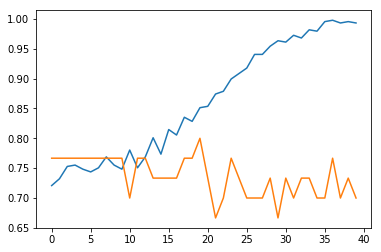

In [16]:
plt.plot([0.7208237986270023, 0.73226544622425627, 0.75286041189931352, 0.75514874141876431, 0.74828375286041193, 0.74370709382151035, 0.75057208237986273, 0.76887871853546907, 0.75514874141876431, 0.74828375286041193, 0.78032036613272315, 0.75057208237986273, 0.76887871853546907, 0.8009153318077803, 0.77345537757437066, 0.81464530892448517, 0.80549199084668188, 0.83524027459954231, 0.82837528604118993, 0.85125858123569798, 0.85354691075514877, 0.87414187643020591, 0.8787185354691075, 0.89931350114416475, 0.90846681922196793, 0.91762013729977121, 0.94050343249427915, 0.94050343249427915, 0.95423340961098402, 0.96338672768878719, 0.9610983981693364, 0.97254004576659037, 0.96796338672768878, 0.98169336384439354, 0.97940503432494275, 0.99542334096109841, 0.99771167048054921, 0.99313501144164762, 0.99542334096109841, 0.99313501144164762])
plt.plot([0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.69999999999999996, 0.76666666666666672, 0.76666666666666672, 0.73333333333333328, 0.73333333333333328, 0.73333333333333328, 0.73333333333333328, 0.76666666666666672, 0.76666666666666672, 0.80000000000000004, 0.73333333333333328, 0.66666666666666663, 0.69999999999999996, 0.76666666666666672, 0.73333333333333328, 0.69999999999999996, 0.69999999999999996, 0.69999999999999996, 0.73333333333333328, 0.66666666666666663, 0.73333333333333328, 0.69999999999999996, 0.73333333333333328, 0.73333333333333328, 0.69999999999999996, 0.69999999999999996, 0.76666666666666672, 0.69999999999999996, 0.73333333333333328, 0.69999999999999996])

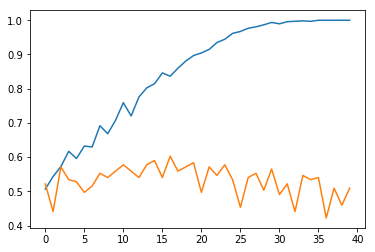

In [17]:
plt.plot([0.50664442591048098, 0.54342507645259941, 0.57250486516541566, 0.61704197942730055, 0.59599666388657213, 0.63227689741451221, 0.62966360856269121, 0.69168751737559075, 0.66836252432582699, 0.70745065332221291, 0.75918821239922163, 0.72035029190992494, 0.77572977481234362, 0.80236308034473169, 0.8145676953016403, 0.8460105643591882, 0.83644703919933272, 0.85999443981095358, 0.8806783430636641, 0.89685849318876842, 0.9044759521823742, 0.91479010286349738, 0.93497358910202943, 0.94445371142618861, 0.96160689463441762, 0.96722268557130953, 0.97653600222407566, 0.9807617458993606, 0.98665554628857377, 0.99360578259660826, 0.98960244648318041, 0.99566305254378651, 0.99708090075062561, 0.99816513761467895, 0.99680289129830424, 0.99994439810953573, 0.99994439810953573, 0.99986099527383931, 1.0, 0.99994439810953573])
plt.plot([0.52173913043478259, 0.44099378881987578, 0.5714285714285714, 0.53416149068322982, 0.52795031055900621, 0.49689440993788814, 0.51552795031055898, 0.55279503105590055, 0.54037267080745344, 0.55900621118012417, 0.57763975155279501, 0.55900621118012417, 0.54037267080745344, 0.57763975155279501, 0.59006211180124224, 0.54037267080745344, 0.60248447204968947, 0.55900621118012417, 0.5714285714285714, 0.58385093167701863, 0.49689440993788825, 0.5714285714285714, 0.54658385093167694, 0.57763975155279501, 0.53416149068322982, 0.45341614906832295, 0.54037267080745344, 0.55279503105590067, 0.50310559006211175, 0.56521739130434789, 0.49068322981366458, 0.52173913043478259, 0.44099378881987578, 0.54658385093167694, 0.53416149068322982, 0.54037267080745344, 0.42236024844720493, 0.50931677018633537, 0.45962732919254656, 0.50931677018633548])

In [ ]:
Accuracies over time for 4 layers                                                                                                                                                  
[0.72540045766590389, 0.75057208237986273, 0.74599542334096114, 0.74828375286041193, 0.74141876430205955, 0.75057208237986273, 0.74828375286041193, 0.73913043478260865, 0.73684210526315785, 0.74599542334096114, 0.74141876430205955, 0.73684210526315785, 0.73226544622425627, 0.73226544622425627, 0.76201372997711669, 0.75514874141876431, 0.76659038901601828, 0.77116704805491987, 0.79405034324942791, 0.77803203661327236, 0.79405034324942791, 0.81922196796338675, 0.83066361556064072, 0.8398169336384439, 0.82379862700228834, 0.86727688787185353, 0.85812356979405036, 0.88558352402745999, 0.86498855835240274, 0.88787185354691078] [0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.76666666666666672, 0.59999999999999998, 0.73333333333333328, 0.56666666666666665, 0.73333333333333328, 0.76666666666666672, 0.69999999999999996, 0.76666666666666672, 0.6333333333333333, 0.76666666666666672, 0.73333333333333328, 0.66666666666666663, 0.73333333333333328, 0.80000000000000004, 0.73333333333333328, 0.73333333333333328, 0.73333333333333328]
ROC AUC over time
[0.48710036141228802, 0.51034195162635532, 0.55540728384765081, 0.49185432304698357, 0.53247150403113708, 0.55668612732832912, 0.56816791770920205, 0.57183764247984425, 0.5952182374200724, 0.61306644425910495, 0.65954962468723943, 0.70219627467333889, 0.72271337225465671, 0.74995829858215179, 0.7638865721434529, 0.79530164025576866, 0.80236308034473169, 0.80436474840144567, 0.84228523769808172, 0.82749513483458426, 0.85474006116207946, 0.87800945232137884, 0.87286627745343348, 0.89110369752571594, 0.89360578259660839, 0.91762579927717536, 0.91912705031971087, 0.93758687795385043, 0.93352793994995831, 0.94715040311370591] [0.49689440993788819, 0.56521739130434789, 0.5714285714285714, 0.44720496894409933, 0.54037267080745344, 0.46583850931677018, 0.55900621118012417, 0.52795031055900621, 0.5714285714285714, 0.61490683229813659, 0.55279503105590067, 0.55279503105590067, 0.53416149068322982, 0.55279503105590067, 0.47826086956521741, 0.49068322981366463, 0.55900621118012428, 0.55279503105590055, 0.47204968944099379, 0.57763975155279501, 0.64596273291925466, 0.51552795031055898, 0.59006211180124224, 0.57763975155279501, 0.48447204968944096, 0.58385093167701863, 0.63354037267080743, 0.58385093167701863, 0.6211180124223602, 0.56521739130434778]
